**BEAR CLASSIFIER**

**Gathering Data**

In [3]:

# pip install azure-cognitiveservices-search-imagesearch
# After signing up at Microsoft, key (actually 2) is granted

from fastai.vision.all import *
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth
key = os.environ.get('AZURE_SEARCH_KEY', 'e2dfb069c7b34cf5b7c31203433840a2')


In [4]:
#Util needed after checking search_image_bing API documentation online

def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])


In [5]:
#To check where the function is defined

search_images_bing

<function __main__.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
#To check whether downloading 150 images was successful

results = search_images_bing(key, 'grizzly bear', min_sz=128)
ims = results.attrgot('content_url')
len(ims)

150

In [7]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [8]:
#Using from fastai's lib download_images function to download the URLs for each search terms. Then, they'll be placed in different folders

bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [9]:
#To check whether folder contains image files as expected

fns = get_image_files(path)
fns

(#390) [Path('bears/grizzly/00000038.jpg'),Path('bears/grizzly/00000010.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000011.jpg'),Path('bears/grizzly/00000039.jpg'),Path('bears/grizzly/00000007.jpg'),Path('bears/grizzly/00000013.jpg'),Path('bears/grizzly/00000012.jpg'),Path('bears/grizzly/00000006.jpg')...]

In [10]:
#check whether download files from internet are corrupted

failed = verify_images(fns)
failed

(#0) []

In [11]:
#Removing all failed images 

failed.map(Path.unlink);

In [12]:

??verify_images

**From Data to DataLoaders**

In [13]:
#DataLoaders just provides data to the model
#using data block API. Allows customize methods in accordance to available data

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

#DataBlock: Providing a tuple specifying the types desired for independent variable (what used to make preditions from - image) and dependent variable (target - categories)
#get_image_files function takes a path and returns the list of all images in that path (recursively by defualt)
#splitter will allow to "randomly" set validation and training set. By fixinf the seed, such dataset will be the same every time notebook is run
#parent_level is a function to create labels in accordance to folder's name such data was stored in
#resize is a transform that allows to resize all the images to same size, so that they can be group in big array (tensor)


In [14]:
#creating dataloader from a given datablock
dls = bears.dataloaders(path)

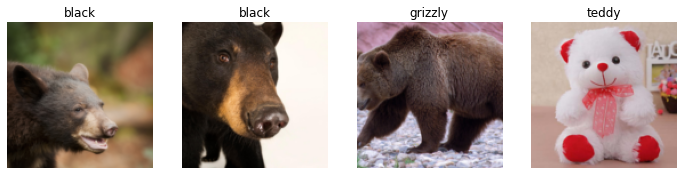

In [15]:
#Dataloaders include both validation and training DataLoaders. Show_batch allows to take a look of data contained in batch
dls.valid.show_batch(max_n=4, nrows=1)

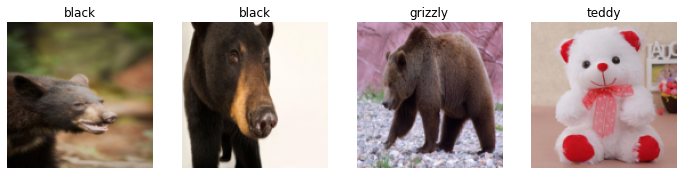

In [16]:
#Playing with squish function
#Approach is problematic due to the fact that generates unrealistic images
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

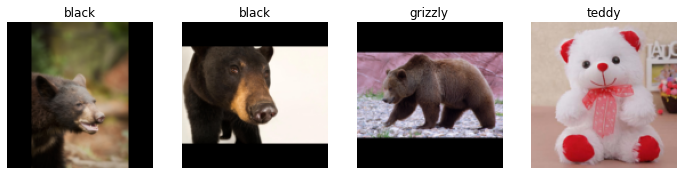

In [17]:
#Playing with pad function
#Approach is wastful in practice due to empty spaces, thus computational waste
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

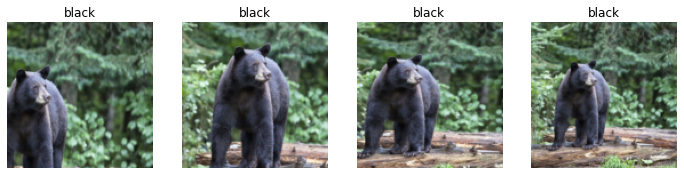

In [18]:
#Playing with Randomcrop function. min_scale determines how much of the image to select at minimum each time
#This approach is valuable because helps to understand to NN the basic concept of what an object is, and how can it be represented
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

#unique=true allow to have the same image

**Data Augmentation**

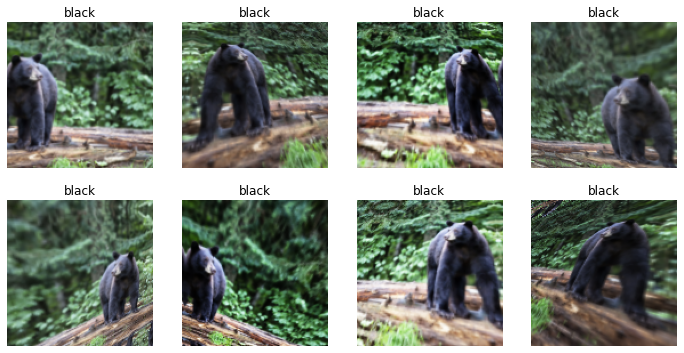

In [19]:
#Data augmentation create random variations (by rotating,flipping, perspective warping, constract and brightness changes) in the input data

bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

**Training The Model, and Using it to Clear the Data**